In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from tqdm import tqdm
from plotnine import *

from unified_model import MechanicalModel
from unified_model import ElectricalModel
from unified_model import mechanical_components
from unified_model import electrical_components
from unified_model import CouplingModel
from unified_model import governing_equations
from unified_model import gridsearch  # <-- The new set of tools we'll be using exist in the `gridsearch` module
from unified_model import optimize

from flux_curve_modelling.model import CurveModel

In [4]:
from numba import errors
import warnings

In [5]:
# Mechanical components
magnetic_spring = mechanical_components.MagneticSpringInterp(
    fea_data_file='./data/magnetic-spring/10x10alt.csv',
    magnet_length=10/1000,
    filter_callable=lambda x: savgol_filter(x, window_length=27, polyorder=5)
)

# NB: This will need to be update for the multi-magnet case!
magnet_assembly = mechanical_components.MagnetAssembly(
    n_magnet=1,
    l_m=10,
    l_mcd=0,
    dia_magnet=10,
    dia_spacer=10
)
mech_spring = mechanical_components.MechanicalSpring(
    position=110/1000,
    damping_coefficient=7.778,
    magnet_length=10/1000
)
damper = mechanical_components.ConstantDamper(0.0433)

# Electrical Components
R_coil = None  # Need to get from `optimize` module
load = electrical_components.SimpleLoad(R=30)
v_rect_drop = 0.1
coupling_model = CouplingModel().set_coupling_constant(4.444)

# Initial flux model
coil_params = {
   'beta': 1361/1000/1000,
    'n_z': 20,
    'n_w': 20,
    'l_th': 2,
    'r_c': 0.143/2,
    'c': 1,
    'm': 1,
    'c_c': 0.059,
    'r_t': 5.5,
}


curve_model = CurveModel.load('./flux_curve_model.model')

# Build our first "template" factory
unified_model_factory = gridsearch.UnifiedModelFactory(
    damper=damper,
    magnet_assembly=magnet_assembly,
    mechanical_spring=mech_spring,
    magnetic_spring=magnetic_spring,
    coil_resistance=None,
    rectification_drop=v_rect_drop,
    load_model=load,
    flux_model=None,
    dflux_model=None,
    coupling_model=coupling_model,
    governing_equations=governing_equations.unified_ode,
    model_id=0,
)

# Choose our input excitations, in the case just one (for now)
acc_input = mechanical_components.AccelerometerInput(
    raw_accelerometer_input='./data/2019-05-23_D/A/log_02_acc.csv',
    accel_column='z_G',
    time_column='time(ms)',
    accel_unit='g',
    time_unit='ms',
    smooth=True,
    interpolate=True
)

# Try evolve it
coil_params['n_z'] = 20
coil_params['n_w'] = 20

simulation_models = optimize.evolve_simulation_set(unified_model_factory=unified_model_factory,
                                                  input_excitations=[acc_input],
                                                  curve_model=curve_model,
                                                  coil_model_params=coil_params)


um = simulation_models[0]

In [16]:
from unified_model.electrical_components.flux.model import FluxModelInterp
import matplotlib.pyplot as plt
from itertools import product
from copy import copy

import ray
ray.init(num_cpus=4, ignore_reinit_error=True)

# Use this
# optimize.precompute_best_spacing()

2020-10-27 22:53:01,379	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '10.0.0.6',
 'raylet_ip_address': '10.0.0.6',
 'redis_address': '10.0.0.6:6379',
 'object_store_address': '/tmp/ray/session_2020-10-27_22-53-00_754441_7495/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-10-27_22-53-00_754441_7495/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2020-10-27_22-53-00_754441_7495',
 'metrics_export_port': 63293}

In [17]:
def batchify(x, batch_size):
    total_size = len(x)
    indexes = np.arange(0, total_size, batch_size)
    
    if indexes[-1] < total_size:
        indexes = np.append(indexes, [total_size])
        
    return [x[indexes[i]:indexes[i+1]] for i in range(len(indexes)-1)]

In [23]:
import pyarrow.parquet as pq
import pyarrow as pa

from itertools import product

n_z_arr = np.arange(2, 101, 1)
n_w_arr = np.arange(2, 101, 1) 

coil_params['c'] = 1

batch_size = 2048
nz_nw_product = np.array(list(product(n_z_arr, n_w_arr)))
n_z_list = []
n_w_list = []
submitted = []

print(f'Pending jobs: {len(nz_nw_product)}')
for batch_num, batch in enumerate(batchify(nz_nw_product, batch_size)):
    for n_z, n_w in batch:
        coil_params['n_z'] = n_z
        coil_params['n_w'] = n_w
        n_z_list.append(n_z)
        n_w_list.append(n_w)

        if coil_params['c'] > 1:
            coil_params['l_ccd'] = optimize.lookup_best_spacing(
                path='optimal_spacing_results.csv',
                n_z=n_z,
                n_w=n_w
            )
        else:
            coil_params['l_ccd'] = 0

        simulation_models = optimize.evolve_simulation_set(unified_model_factory=unified_model_factory,
                                                          input_excitations=[acc_input],
                                                          curve_model=curve_model,
                                                          coil_model_params=coil_params)

        um = simulation_models[0]
        submitted.append(optimize.simulate_unified_model.remote(um))
        
    print(f'Total submitted: {len(submitted)*(batch_num+1)}')
    print('Waiting for batch to complete...')
    ready = []
    while len(ready) < len(submitted):  # Wait for batch to complete
        ready, waiting = ray.wait(submitted, num_returns=len(submitted), timeout=60)
        print(f'Completed: {len(ready)} out of {len(submitted)}')

    # Process results
    results = ray.get(ready)
    df = pd.DataFrame({
        'n_z': n_z_list,
        'n_w': n_w_list,
        'rms': [r['rms'] for r in results]
    })
    table = pa.Table.from_pandas(df) 
    pq.write_to_dataset(table, '1c1m_test_optimization.parquet')

    # Clear
    del results
    del df
    del table

    submitted = []
    n_z_list = []
    n_w_list = []

Pending jobs: 9801
Total submitted: 2048
Waiting for batch to complete...
Completed: 315 out of 2048
Completed: 432 out of 2048
Completed: 549 out of 2048
Completed: 666 out of 2048
Completed: 783 out of 2048
Completed: 898 out of 2048
Completed: 1016 out of 2048
Completed: 1132 out of 2048
Completed: 1250 out of 2048
Completed: 1364 out of 2048
Completed: 1479 out of 2048
Completed: 1597 out of 2048
Completed: 1713 out of 2048
Completed: 1829 out of 2048
Completed: 1947 out of 2048
Completed: 2048 out of 2048
Total submitted: 4096
Waiting for batch to complete...
Completed: 309 out of 2048
Completed: 420 out of 2048
Completed: 536 out of 2048
Completed: 652 out of 2048
Completed: 768 out of 2048
Completed: 886 out of 2048
Completed: 1003 out of 2048
Completed: 1121 out of 2048
Completed: 1239 out of 2048
Completed: 1356 out of 2048
Completed: 1473 out of 2048
Completed: 1585 out of 2048
Completed: 1702 out of 2048
Completed: 1819 out of 2048
Completed: 1933 out of 2048
Completed: 2048

In [6]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
from itertools import product

In [7]:
def get_emf(n_z, n_w, c, coil_params):
    coil_params['n_z']=n_z
    coil_params['n_w']=n_w
    coil_params['c']=c
    coil_params['m']=1
    coil_params['l_ccd']=optimize.lookup_best_spacing('optimal_spacing_results.csv', coil_params['n_z'], coil_params['n_w'])
    z_arr = np.linspace(0, 0.2, 1000)
    flux, dflux = optimize.get_new_flux_and_dflux_model(curve_model, coil_params)
    return z_arr, dflux.get(z_arr)

def get_vload(n_z, n_w, c, coil_params, r_load):
    r_coil = optimize._get_coil_resistance(**coil_params)
    z_arr, emf = get_emf(n_z, n_w, c, coil_params)
    v_load = emf*(r_load/(r_load+r_coil))
    return z_arr, v_load

def get_load_rms(n_z, n_w, c, coil_params, r_load):
    _, v_load = get_vload(n_z, n_w, c, coil_params, r_load)
    return optimize.calc_rms(v_load)

def constant_velocity_gridsearch(n_z_arr, n_w_arr, c, coil_params, r_load):
    load_power = []
    n_z_list = []
    n_w_list = []  # ugly
    r_c_list = []
    for n_z, n_w in tqdm(list(product(n_z_arr, n_w_arr))):
        v_load_rms = get_load_rms(n_z, n_w, c, coil_params, r_load)
        load_power.append((v_load_rms**2)/r_load)
        n_z_list.append(n_z)
        n_w_list.append(n_w)
        r_c_list.append(optimize._get_coil_resistance(**coil_params))
    
    df = pd.DataFrame({
        'n_z': n_z_list,
        'n_w': n_w_list,
        'p_avg': load_power,
        'r_coil': r_c_list
    })
    
    return df
    
n_z_arr = np.arange(1, 100, 10)
n_w_arr = np.arange(1, 100, 10)
df_1c1m = constant_velocity_gridsearch(n_z_arr, n_w_arr, 1, coil_params, r_load=30) 
df_2c1m = constant_velocity_gridsearch(n_z_arr, n_w_arr, 2, coil_params, r_load=30) 


100%|██████████| 2500/2500 [03:59<00:00, 10.42it/s]


In [8]:
def get_load_power(n_z, n_w, c, coil_params, r_load):
    z_arr, v_load = get_vload(n_z, n_w, c, coil_params, r_load)
    return z_arr, v_load*v_load/r_load

In [9]:
df_1c1m.sort_values(by='p_avg', ascending=False).head()

,n_z,n_w,p_avg,r_coil
2456,99,13,0.002127,94.346118
2406,97,13,0.002126,92.440136
2356,95,13,0.002123,90.534153
2455,99,11,0.002123,78.499644
2306,93,13,0.002119,88.628171


In [10]:
df_2c1m.sort_values(by='p_avg', ascending=False).head()

,n_z,n_w,p_avg,r_coil
2451,99,3,0.002525,39.912491
2401,97,3,0.002479,39.106178
2452,99,5,0.002466,67.731441
2402,97,5,0.002449,66.363129
2351,95,3,0.002431,38.299865


In [11]:
plt.plot(*get_load_power())

NameError: name 'plt' is not defined

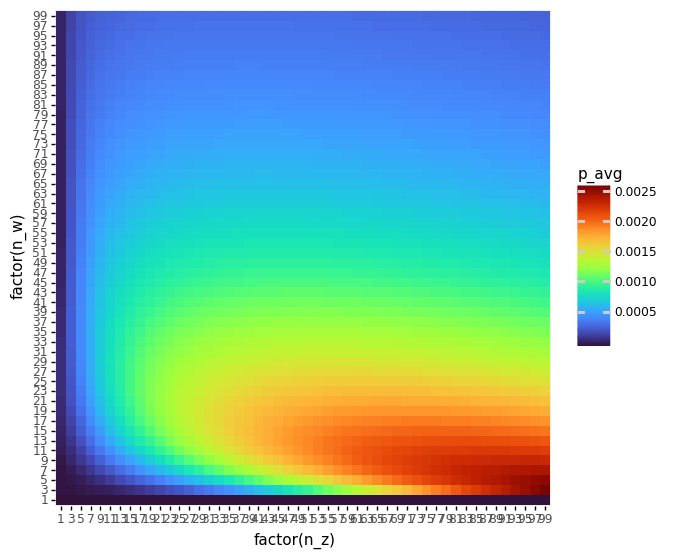

<ggplot: (8730235628829)>

In [12]:
from plotnine import *
p = ggplot(aes(x='factor(n_z)', y='factor(n_w)', fill='p_avg'), df_2c1m)
p + geom_tile() + coord_equal() + scale_fill_cmap('turbo')


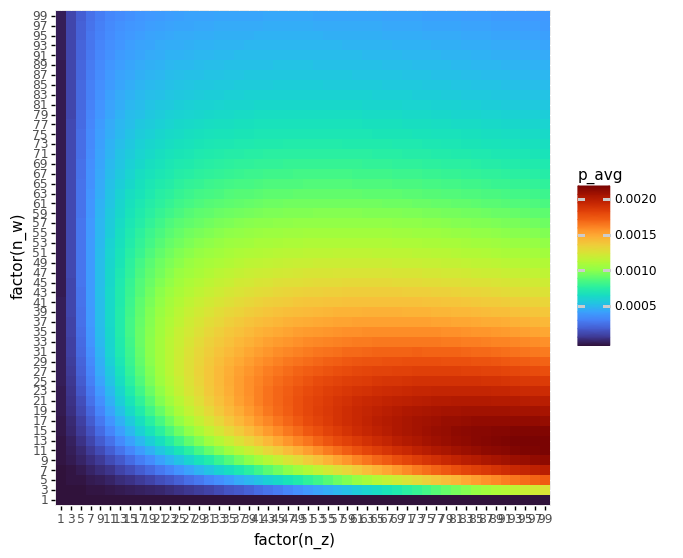

<ggplot: (8730235618237)>

In [13]:
p = ggplot(aes(x='factor(n_z)', y='factor(n_w)', fill='p_avg'), df_1c1m)
p + geom_tile() + coord_equal() + scale_fill_cmap('turbo')

62.06959210997357
0.17345223508176447


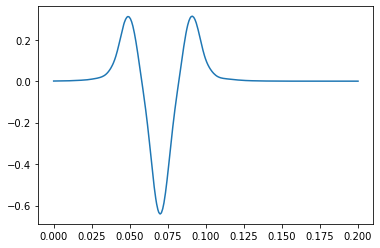

In [77]:
coil_params['n_z']=20
coil_params['n_w']=20
coil_params['c'] = 2
coil_params['l_ccd']=optimize.lookup_best_spacing('optimal_spacing_results.csv', coil_params['n_z'], coil_params['n_w'])
r_coil = optimize._get_coil_resistance(**coil_params)
print(r_coil)
r_load = 30
z_arr = np.linspace(0, 0.2, 1000)
flux, dflux = optimize.get_new_flux_and_dflux_model(curve_model,coil_params)
v_load = dflux.get(z_arr)*r_load/(r_load+r_coil)
plt.plot(z_arr, v_load)
print(optimize.calc_rms(v_load))

0.22213418020150033


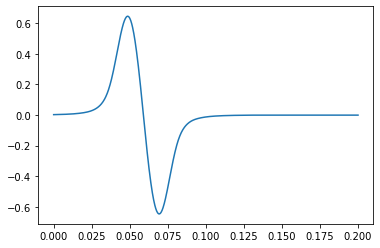

In [57]:
coil_params['n_z']=92
coil_params['n_w']=19
coil_params['c'] = 1
r_coil = optimize._get_coil_resistance(**coil_params)
r_load = 30
z_arr = np.linspace(0, 0.2, 1000)
flux, dflux = optimize.get_new_flux_and_dflux_model(curve_model,coil_params)
v_load = dflux.get(z_arr)*r_load/(r_load+r_coil)
plt.plot(z_arr, v_load)
print(optimize.calc_rms(v_load))

In [3]:
df_1c1m = pq.read_table('1c1m_test_optimization.parquet').to_pandas()
df_2c1m = pq.read_table('2c1m_test_optimization.parquet').to_pandas()

,n_z,n_w,rms
0,43,39,0.075462
1,43,40,0.074873
2,43,41,0.074312
3,43,42,0.073897
4,43,43,0.073154


In [25]:
df_1c1m.sort_values(by='rms', ascending=False).head(10)

,n_z,n_w,rms
5629,100,25,0.091752
7233,79,51,0.091305
5323,97,16,0.088923
4633,90,19,0.088786
4138,85,19,0.088775
4435,88,19,0.088736
5028,94,18,0.088716
5127,95,18,0.088692
4634,90,20,0.088663
4831,92,19,0.088657


In [26]:
df_2c1m.sort_values(by='rms', ascending=False).head(10)

,n_z,n_w,rms
9145,78,14,0.076539
9047,77,15,0.076503
8849,75,15,0.076440
8948,76,15,0.076424
9343,80,14,0.076412
8552,72,15,0.076388
8651,73,15,0.076379
9540,82,13,0.076369
8553,72,16,0.076361
8850,75,16,0.076359


In [11]:
from plotnine import *

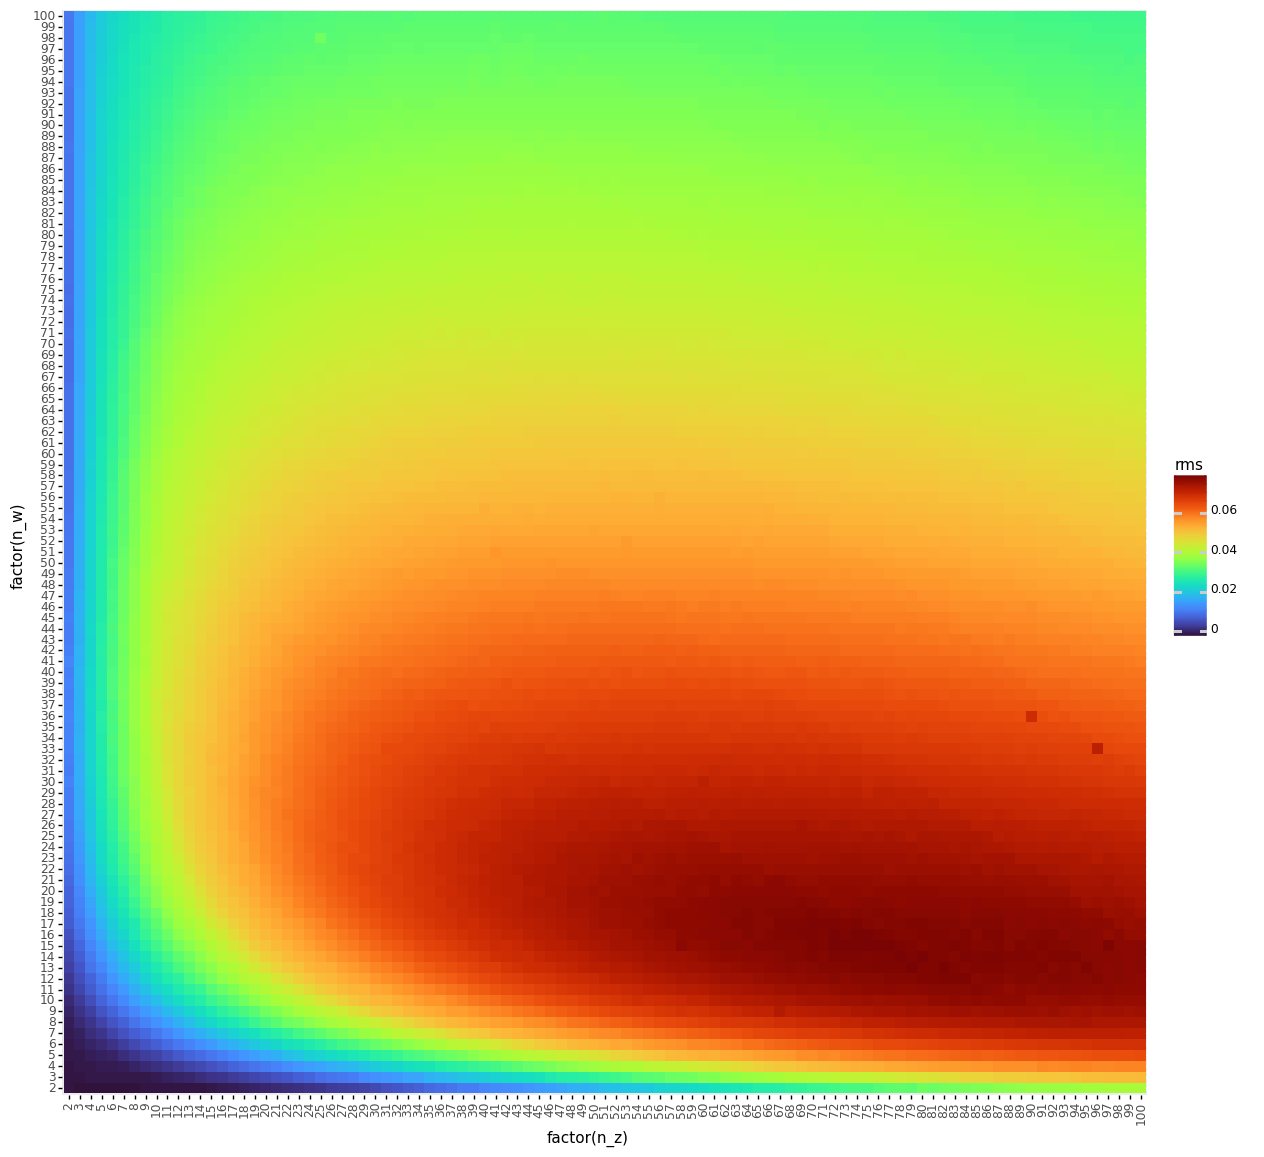

<ggplot: (8794331562733)>

In [28]:
p = ggplot(aes(x='factor(n_z)', y='factor(n_w)', fill='rms'), df)
p + geom_tile() + coord_equal() + theme(axis_text_x=element_text(angle=90), figure_size=(14, 9)) + scale_fill_cmap('turbo')

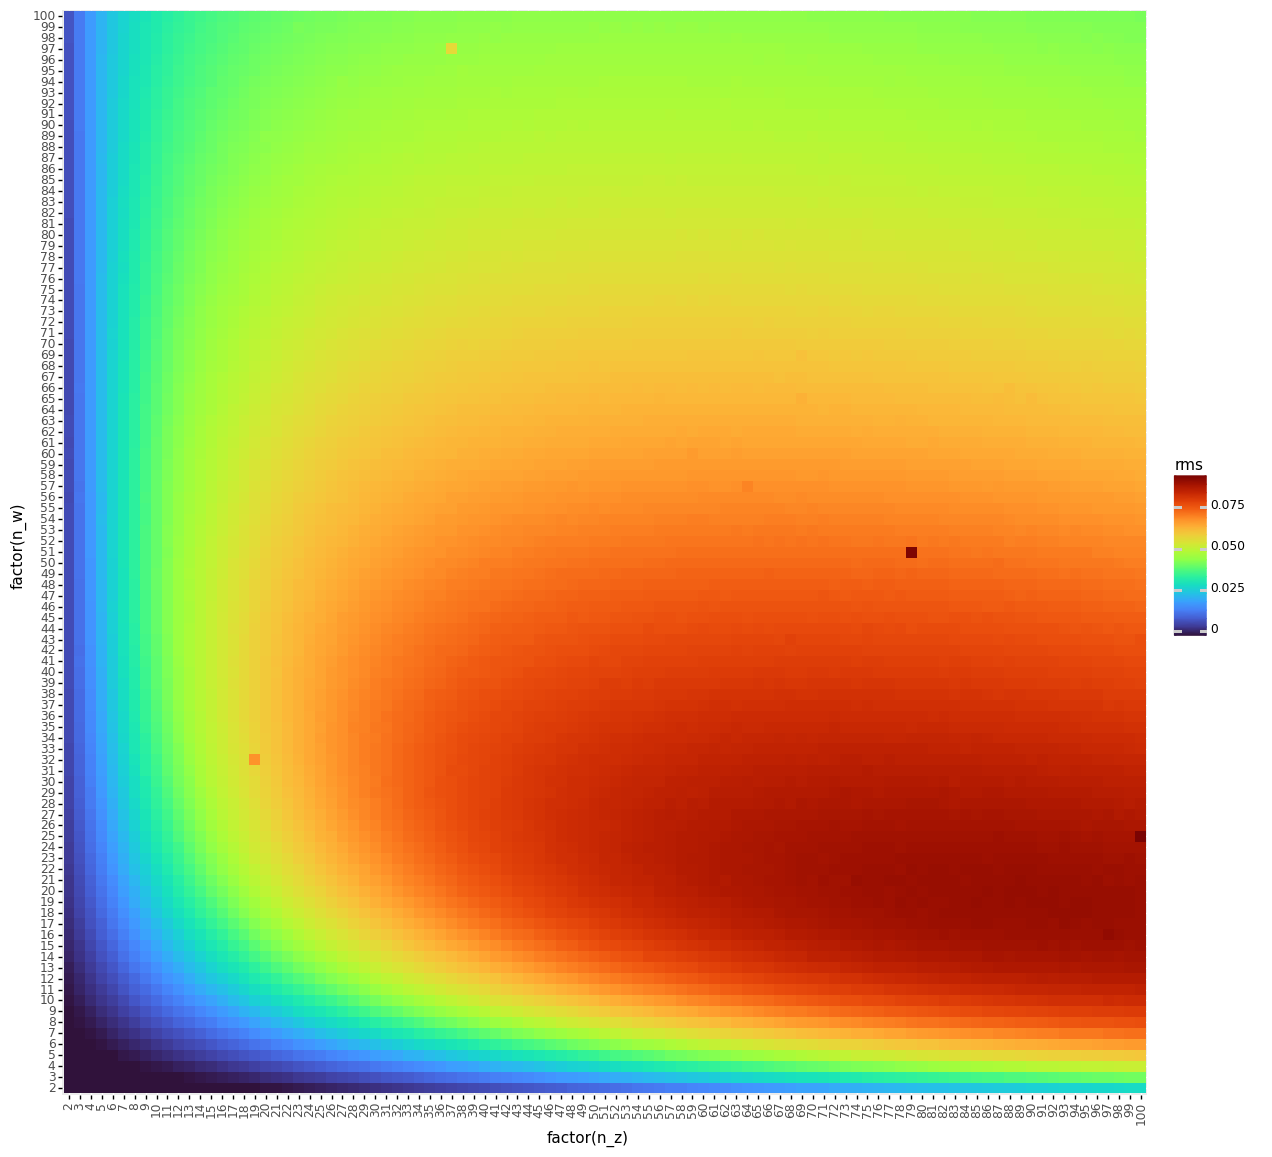

<ggplot: (8794692138041)>

In [26]:
p = ggplot(aes(x='factor(n_z)', y='factor(n_w)', fill='rms'), df)
p + geom_tile() + coord_equal() + theme(axis_text_x=element_text(angle=90), figure_size=(14, 9)) + scale_fill_cmap('turbo')

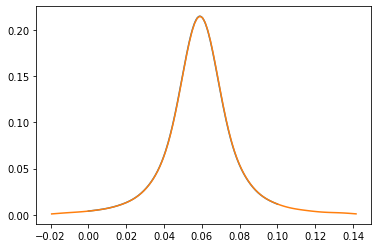

In [234]:
# Double check we get the same flux curves
coil_params['n_z'] = 55
coil_params['n_w'] = 145

simulation_models = optimize.evolve_simulation_set(
    unified_model_factory=unified_model_factory,
    input_excitations=[acc_input],
    curve_model=curve_model,
    coil_model_params=coil_params)

um = simulation_models[0]


xs = np.linspace(0, 0.1, 1000)
phi_from_model = [um.electrical_model.flux_model.get(x) for x in xs]
plt.plot(xs, phi_from_model)

xs, phi = curve_model.predict_curve([[coil_params['n_z'], coil_params['n_w']]])
plt.plot(xs + 0.059, phi.flatten())

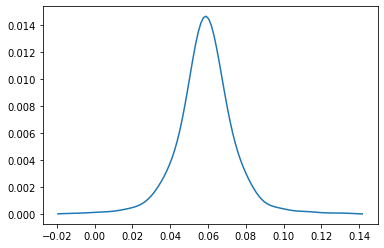

In [188]:
xs, phi = curve_model.predict_curve([[5, 95]])
plt.plot(xs + 0.059, phi.flatten())

# xs, phi = curve_model.predict_curve([[15, 65]])
# plt.plot(xs, phi.flatten())